#


# BTL1 môn Học Máy, mã môn học CO3117 - Học máy với dữ liệu bảng
## **Thông tin nhóm**

+ **Tên nhóm** : MLP2
+ **Giảng viên hướng dẫn**: TS. Lê Thành Sách
+ **Thành viên** :

    | **MSSV** | **Họ và tên** |
    |:---|:---:|
    | 2312046 | Bùi Ngọc Minh |
    | 2313233 | Lê Trọng Thiện |


## **Dataset**
Dữ liệu cho collab này bao gồm hơn 10k entries về các chi tiết của các mẫu xe, dùng để dự đoán giá thành của mẫu xe đó.

Dữ liệu này được lấy tại [kraggle](https://www.kaggle.com/datasets/CooperUnion/cardataset/data).

## **Nội dung**
File collab này áp dụng pipeline học máy truyền thống cho bộ dữ liệu, cùng với việc so sánh kết qủa dự đoán của các model học máy truyền thống.

# Chuẩn bị các thư viện



In [16]:
import numpy as np
import pandas as pd
import os, random
import sklearn
import kagglehub
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# models
from sklearn.linear_model import LinearRegression, Lasso, Ridge # noted in requirements
from sklearn.svm import SVR # SVM - noted in requirements
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report



RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

#Chuẩn bị dữ liệu
Tải dữ liệu từ đường dẫn https://www.kaggle.com/datasets/CooperUnion/cardataset/data.

In [17]:
path = kagglehub.dataset_download("CooperUnion/cardataset")
print("Download and Load data at: " + path)

Download and Load data at: C:\Users\ADMIN\.cache\kagglehub\datasets\CooperUnion\cardataset\versions\1




# Phân tích và xử lý dữ liệu

In [18]:
df = pd.read_csv(path + '/data.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()



,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_fuel_type   11911 non-null  object 
 4   engine_hp          11845 non-null  float64
 5   engine_cylinders   11884 non-null  float64
 6   transmission_type  11914 non-null  object 
 7   driven_wheels      11914 non-null  object 
 8   number_of_doors    11908 non-null  float64
 9   market_category    8172 non-null   object 
 10  vehicle_size       11914 non-null  object 
 11  vehicle_style      11914 non-null  object 
 12  highway_mpg        11914 non-null  int64  
 13  city_mpg           11914 non-null  int64  
 14  popularity         11914 non-null  int64  
 15  msrp               11914 non-null  int64  
dtypes: float64(3), int64(5

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,11914.0,2010.384338,7.579740,1990.0,2007.0,2015.0,2016.00,2017.0
engine_hp,11845.0,249.386070,109.191870,55.0,170.0,227.0,300.00,1001.0
engine_cylinders,11884.0,5.628829,1.780559,0.0,4.0,6.0,6.00,16.0
number_of_doors,11908.0,3.436093,0.881315,2.0,2.0,4.0,4.00,4.0
highway_mpg,11914.0,26.637485,8.863001,12.0,22.0,26.0,30.00,354.0
city_mpg,11914.0,19.733255,8.987798,7.0,16.0,18.0,22.00,137.0
popularity,11914.0,1554.911197,1441.855347,2.0,549.0,1385.0,2009.00,5657.0
msrp,11914.0,40594.737032,60109.103604,2000.0,21000.0,29995.0,42231.25,2065902.0


In [21]:
missing_data = df.isnull().sum() / len(df) * 100
print(missing_data)

make                  0.000000
model                 0.000000
year                  0.000000
engine_fuel_type      0.025180
engine_hp             0.579151
engine_cylinders      0.251805
transmission_type     0.000000
driven_wheels         0.000000
number_of_doors       0.050361
market_category      31.408427
vehicle_size          0.000000
vehicle_style         0.000000
highway_mpg           0.000000
city_mpg              0.000000
popularity            0.000000
msrp                  0.000000
dtype: float64


In [22]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (715, 16)


Kiểm tra dữ liệu cho thấy cột market_category có tỷ lệ missing data rất cao nền cần phải loại bỏ khỏi data frame.

In [23]:
df=df.drop(columns=['market_category'])
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11194 entries, 0 to 11913
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11194 non-null  object 
 1   model              11194 non-null  object 
 2   year               11194 non-null  int64  
 3   engine_fuel_type   11191 non-null  object 
 4   engine_hp          11125 non-null  float64
 5   engine_cylinders   11164 non-null  float64
 6   transmission_type  11194 non-null  object 
 7   driven_wheels      11194 non-null  object 
 8   number_of_doors    11188 non-null  float64
 9   vehicle_size       11194 non-null  object 
 10  vehicle_style      11194 non-null  object 
 11  highway_mpg        11194 non-null  int64  
 12  city_mpg           11194 non-null  int64  
 13  popularity         11194 non-null  int64  
 14  msrp               11194 non-null  int64  
dtypes: float64(3), int64(5), object(7)
memory usage: 1.4+ MB


In [24]:
fig1 = px.histogram(df, x="msrp", nbins=50, title="MSRP Distribution")
fig1.show()

Kiểm tra phân phối của cột mục tiêu cho thấy phần lớn giá trị tập trung vào bên trái của đồ thị.

In [25]:
#IRQ
Q1 = df["msrp"].quantile(0.25)
Q3 = df["msrp"].quantile(0.75)
IQR = Q3 - Q1

df = df[df["msrp"].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)]
print(df.shape)

(10235, 15)


Loại bỏ các giá trị ngoại biên để làm sạch dữ liệu.

In [26]:

fig2 = px.histogram(df, x="msrp", nbins=50, title="MSRP Distribution")
fig2.show()

In [27]:
df_nums = df.select_dtypes(include="number")
df_nums.head()

,year,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity,msrp
0,2011,335.0,6.0,2.0,26,19,3916,46135
1,2011,300.0,6.0,2.0,28,19,3916,40650
2,2011,300.0,6.0,2.0,28,20,3916,36350
3,2011,230.0,6.0,2.0,28,18,3916,29450
4,2011,230.0,6.0,2.0,28,18,3916,34500


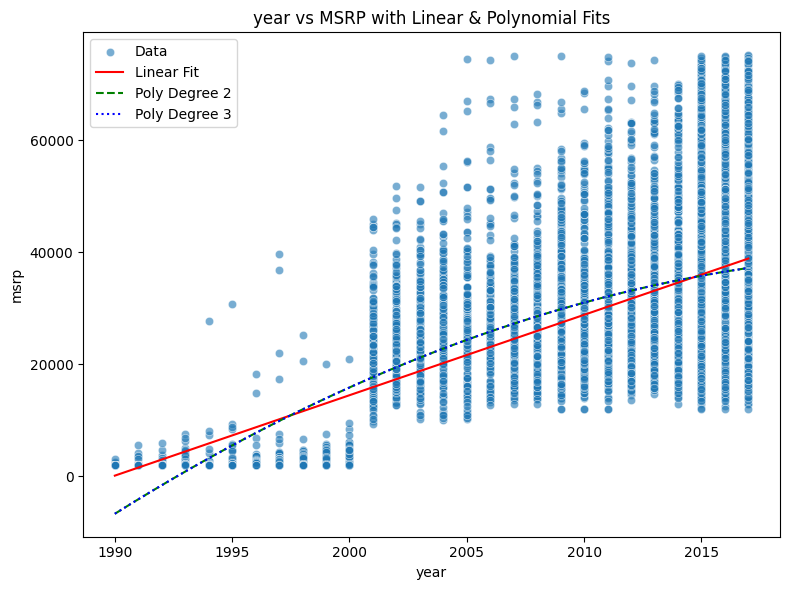

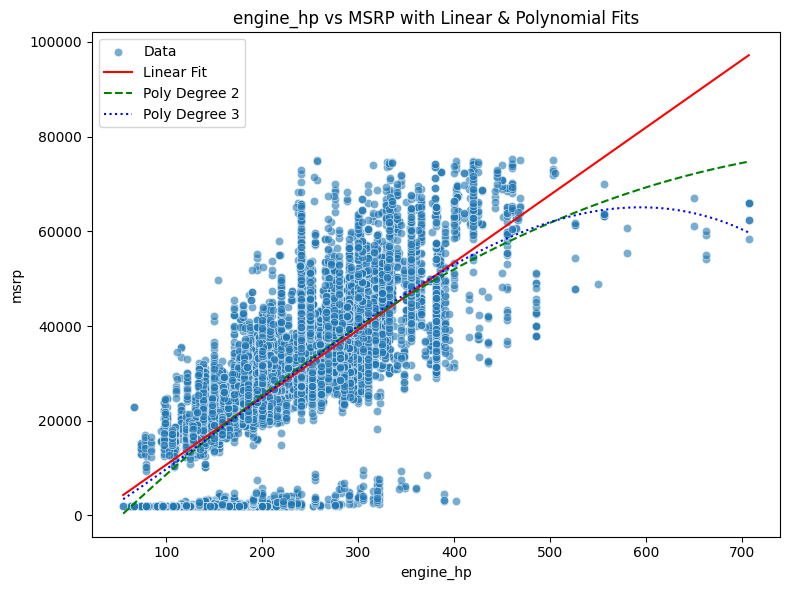

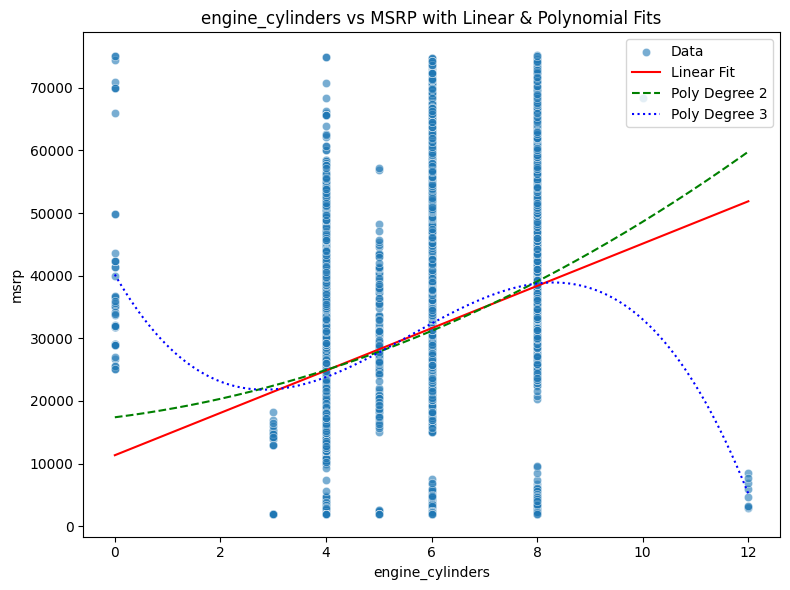

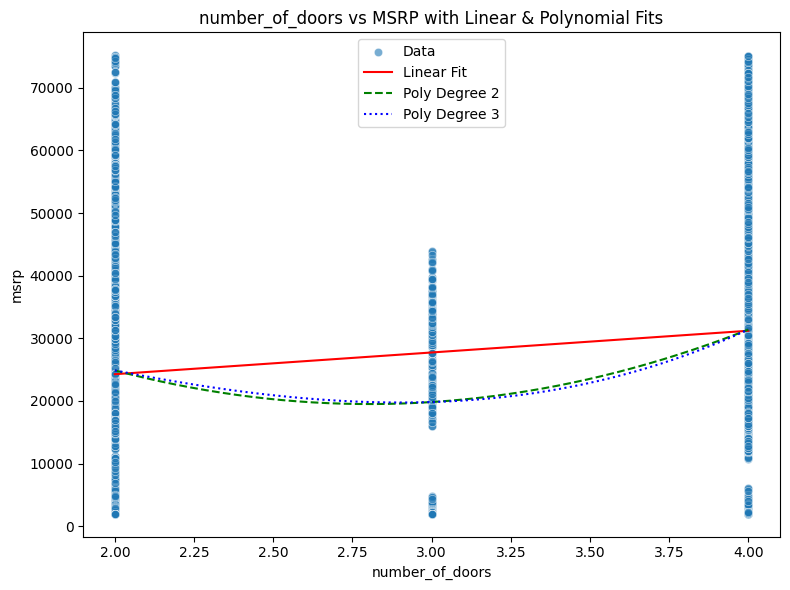

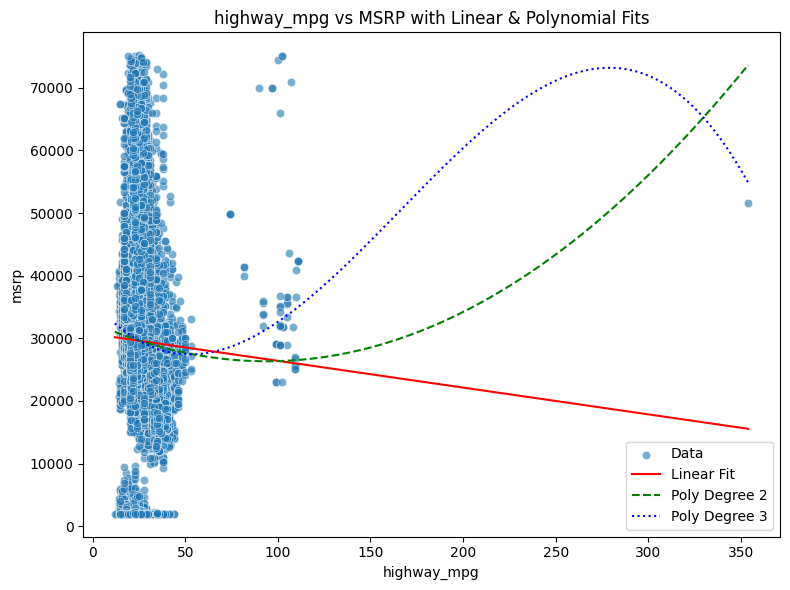

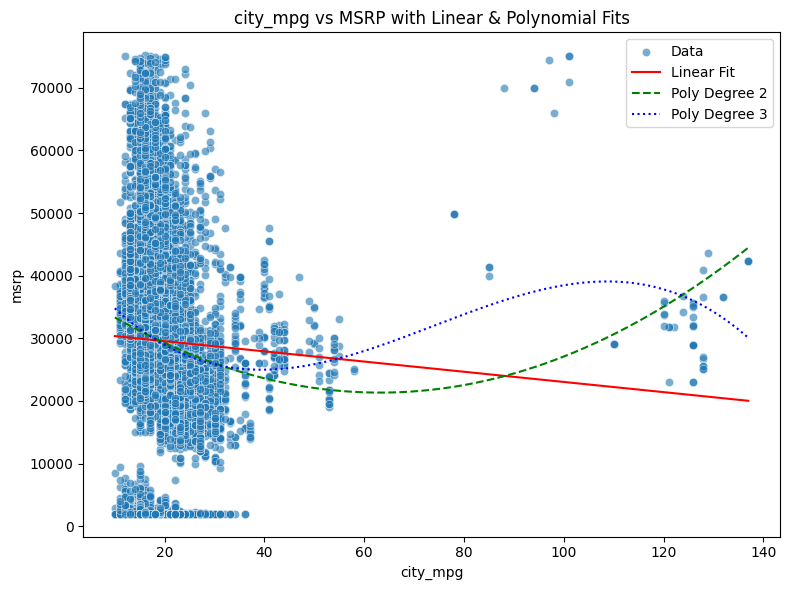

In [28]:


for column in df_nums.columns[:-2]:
    df_sub = df_nums[[column, "msrp"]].dropna()
    X = df_sub[[column]].values
    y = df_sub["msrp"].values

    x_range = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)

    lin_reg = LinearRegression().fit(X, y)
    y_lin_pred = lin_reg.predict(x_range)

    poly2 = PolynomialFeatures(degree=2)
    X_poly2 = poly2.fit_transform(X)
    lin_reg2 = LinearRegression().fit(X_poly2, y)
    y_poly2_pred = lin_reg2.predict(poly2.transform(x_range))

    poly3 = PolynomialFeatures(degree=3)
    X_poly3 = poly3.fit_transform(X)
    lin_reg3 = LinearRegression().fit(X_poly3, y)
    y_poly3_pred = lin_reg3.predict(poly3.transform(x_range))

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X.flatten(), y=y, label="Data", alpha=0.6)
    plt.plot(x_range, y_lin_pred, color="red", label="Linear Fit")
    plt.plot(x_range, y_poly2_pred, color="green", linestyle='--', label="Poly Degree 2")
    plt.plot(x_range, y_poly3_pred, color="blue", linestyle=':', label="Poly Degree 3")

    plt.xlabel(column)
    plt.ylabel("msrp")
    plt.title(f"{column} vs MSRP with Linear & Polynomial Fits")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [29]:
c_table = df_nums.corr()
fig4 = px.imshow(c_table, text_auto=True, color_continuous_scale='RdBu_r', title='Correlation Heatmap', width=800, height=800)
fig4.update_traces(textfont_size=9.5)
fig4.show()

Qua các biểu đồ ta thấy được quan hệ các biến với *mrsp*

*   Các biến *engine_hp* và *year* có quan hệ tương quan dương mạnh với msrp
*   Các biến *engine_cylinder* và *number_of_door* có quan hệ yếu
*   Hai biến *city_mpg* và *highway_mpg* có tương quan âm và có thể gây đa cộng tuyến





# Thiết lập mô hình pipeline

In [30]:
target = "msrp"
X = df.drop(columns=[target])
y = df[target]

In [31]:
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
print("Numerical:", num_cols)
print("Categorical:", cat_cols)

Numerical: ['year', 'engine_hp', 'engine_cylinders', 'number_of_doors', 'highway_mpg', 'city_mpg', 'popularity']
Categorical: ['make', 'model', 'engine_fuel_type', 'transmission_type', 'driven_wheels', 'vehicle_size', 'vehicle_style']


In [32]:
# hyper parameters
_precision = 7
_pca = .90
_test_size = .2 # 20% of the data is in the test set
_scaler = "standard" # or MinMaxScaler



*   Dùng PCA với mức giữ lại phương sai là 90%
*   Chia mẫu train : test là 80:20




In [33]:
if(_scaler == "standard") :
  num_pipe = Pipeline([
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler())
  ])
else :
  num_pipe = Pipeline([
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', MinMaxScaler(feature_range=(0,1)))
  ])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

Đối với cột dữ liệu số:

*   Thực hiện imputation missing data bằng cách thay bằng giá trị trung vị.
*   Dùng StandardScaler

Đối với cột dữ liệu phân loại:
* Xử lý missing data bằng cách thay vào giá trị có tần suất nhiều nhất
* Dùng OneHotEndcoder


In [34]:
pca = PCA(n_components=_pca, svd_solver='covariance_eigh') # or arpack

In [35]:
# Regression models
models_list = {
    "Linear Regression": LinearRegression(), #0.3s
    "Lasso Regression": Lasso(alpha=0.01), #0.3s
    "Random Forest Regressor, n=50": RandomForestRegressor(n_estimators=50, random_state=42), #30s
    "Random Forest Regressor, n=100": RandomForestRegressor(n_estimators=100, random_state=42), #1m
    "Support Vector Regressor, C=200, epsilon=1": SVR(kernel="rbf", C=200, epsilon=1), 
    "Support Vector Regressor, C=5000, epsilon=25": SVR(kernel="rbf", C=5000, epsilon=25), 
    "Support Vector Regressor, C=10000, epsilon=50": SVR(kernel="rbf", C=10000, epsilon=50), 
    "KNN Regressor, k=5": KNeighborsRegressor(n_neighbors=5), #0.2s
    "KNN Regressor, k=10": KNeighborsRegressor(n_neighbors=10), #0.2s
    "KNN Regressor, k=50": KNeighborsRegressor(n_neighbors=50), #0.2s
}

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=_test_size, random_state=RANDOM_STATE)

# Chạy mô hình

Training Linear Regression
Finished training in 0.3380 seconds


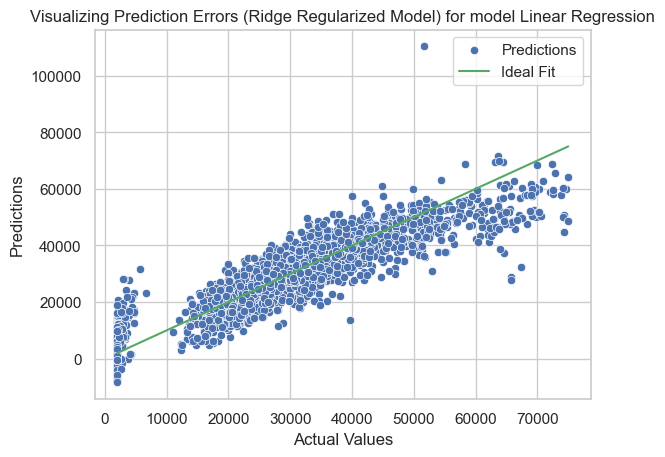

Training Lasso Regression
Finished training in 0.3302 seconds


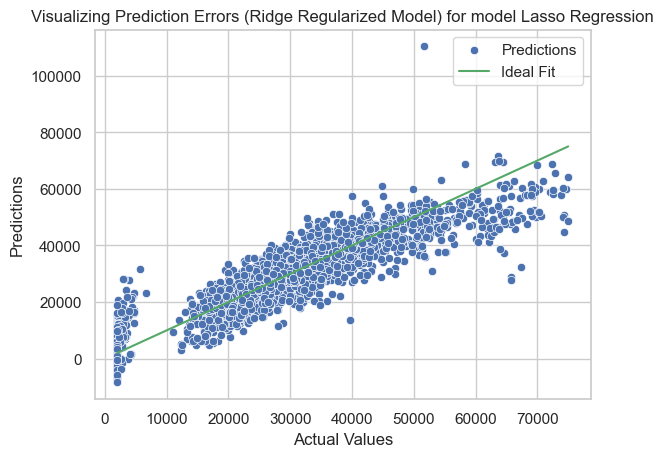

Training Random Forest Regressor, n=50
Finished training in 12.9073 seconds


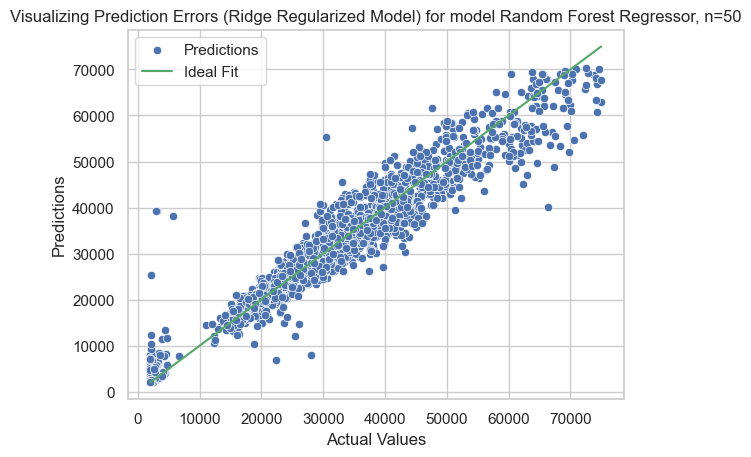

Training Random Forest Regressor, n=100
Finished training in 25.8705 seconds


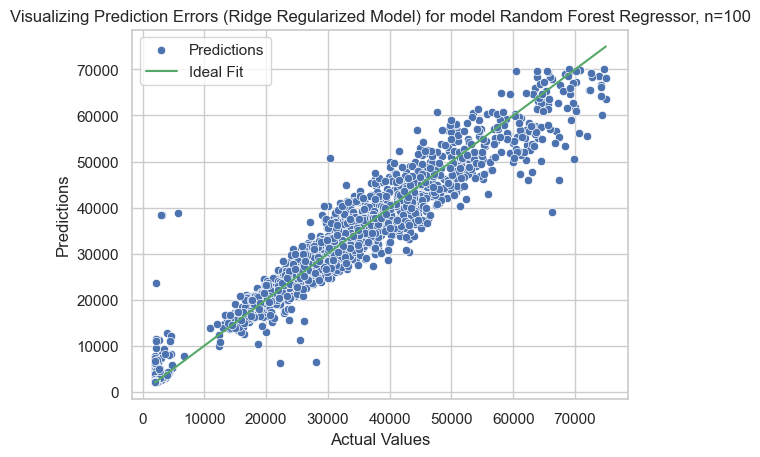

Training Support Vector Regressor, C=200, epsilon=1
Finished training in 3.2878 seconds


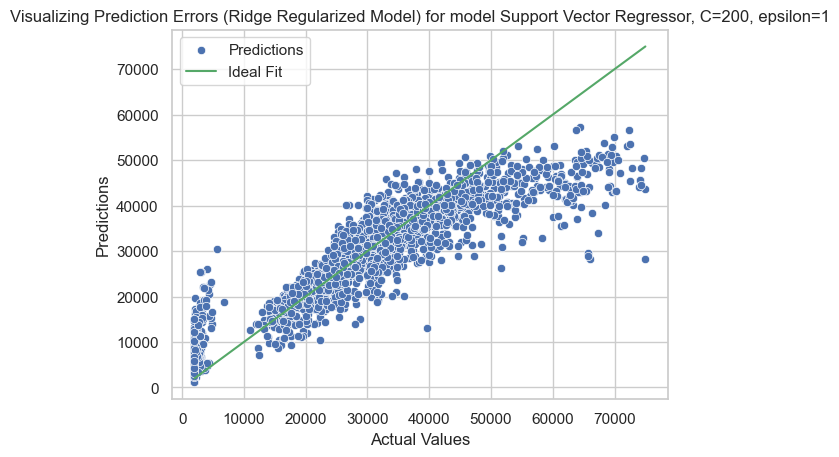

Training Support Vector Regressor, C=5000, epsilon=25
Finished training in 3.4493 seconds


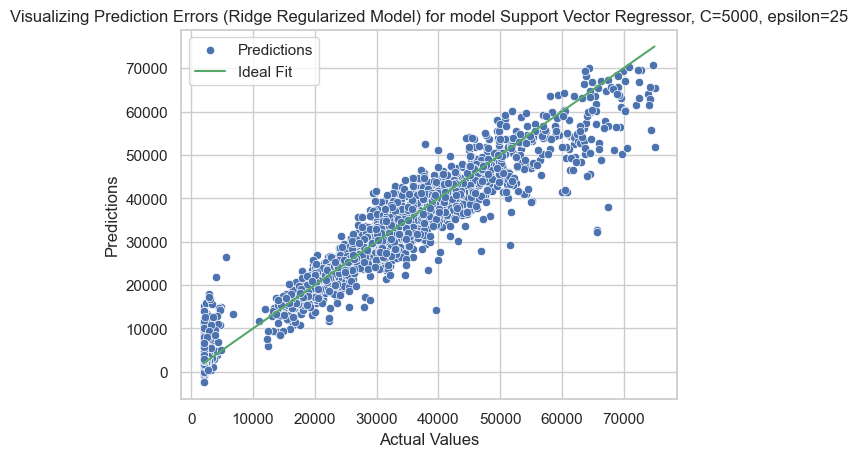

Training Support Vector Regressor, C=10000, epsilon=50
Finished training in 3.6500 seconds


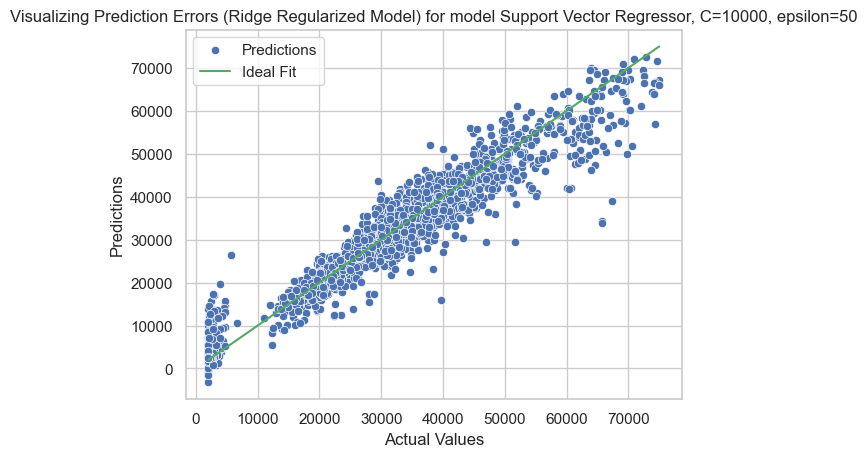

Training KNN Regressor, k=5
Finished training in 0.3707 seconds


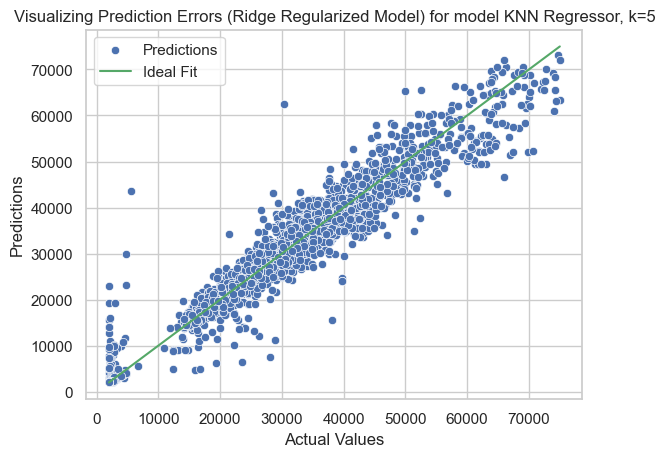

Training KNN Regressor, k=10
Finished training in 0.3688 seconds


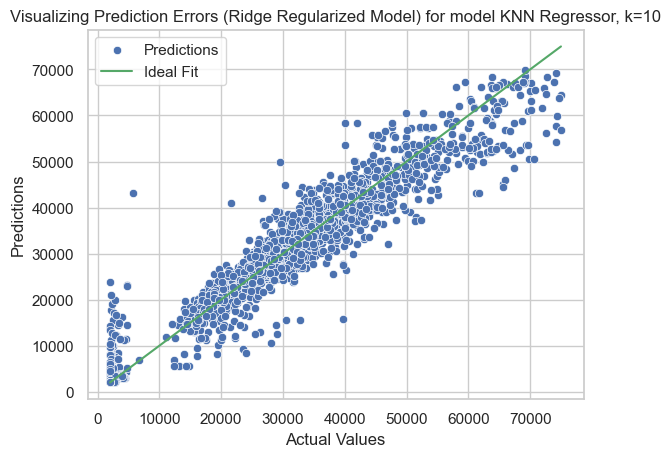

Training KNN Regressor, k=50
Finished training in 0.3803 seconds


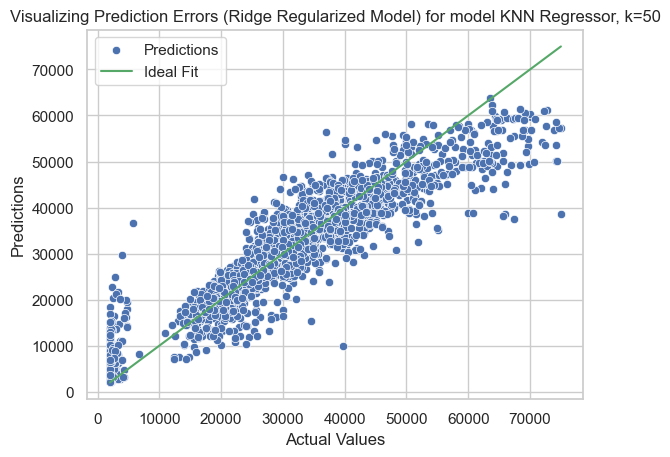

,model,train_mse,train_r2,test_mse,test_r2
0,Linear Regression,4.580182e+07,0.8186957,4.90171e+07,0.8067723
1,Lasso Regression,4.580182e+07,0.8186957,4.901706e+07,0.8067725
2,"Random Forest Regressor, n=50",5.311011e+06,0.9789766,1.667533e+07,0.9342651
3,"Random Forest Regressor, n=100",5.233212e+06,0.9792846,1.642521e+07,0.9352511
4,"Support Vector Regressor, C=200, epsilon=1",5.074139e+07,0.7991426,5.394508e+07,0.787346
5,"Support Vector Regressor, C=5000, epsilon=25",1.878993e+07,0.925621,2.164474e+07,0.9146754
6,"Support Vector Regressor, C=10000, epsilon=50",1.612077e+07,0.9361867,1.903983e+07,0.9249441
7,"KNN Regressor, k=5",1.181365e+07,0.9532362,1.788586e+07,0.9294931
8,"KNN Regressor, k=10",1.825756e+07,0.9277283,2.238391e+07,0.9117616
9,"KNN Regressor, k=50",3.491725e+07,0.8617817,3.651157e+07,0.8560697


In [47]:
import time

# fit models
model_scores = []
for name, model in models_list.items():
    start_time = time.perf_counter()
    print("Training "+ name)
    clf = Pipeline([
        ('preproc', preprocessor),
        ('pca', pca),
        ('model', model)
    ])

    clf.fit(X_train, y_train)

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f"Finished training in {elapsed_time:.4f} seconds")
    # train predictions
    # Predict on train set
    y_train_pred = clf.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)


    # Predict on test set
    y_test_pred = clf.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    thisModelScores = [
          # Statistical metrics
          mse_train,
        r2_train ,
          mse_test,
          r2_test,
        ]

    thisModelScores = [f"{x:.{_precision}}" for x in thisModelScores]
    thisModelScores.insert(0, name)
    model_scores.append(thisModelScores)

    # graph predictions
    plt.figure()
    sns.scatterplot(x=y_test, y=y_test_pred, label="Predictions")
    sns.lineplot(x=y_test, y=y_test, color="g", label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predictions")
    plt.title(f"Visualizing Prediction Errors (Ridge Regularized Model) for model {name}")
    plt.show()


#Outside train loop
model_scores = pd.DataFrame(model_scores)
model_scores.columns = [
      "model",

      "train_mse",
      "train_r2",
      "test_mse",
      "test_r2",
    ]
model_scores


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7284\3641452439.py:66: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



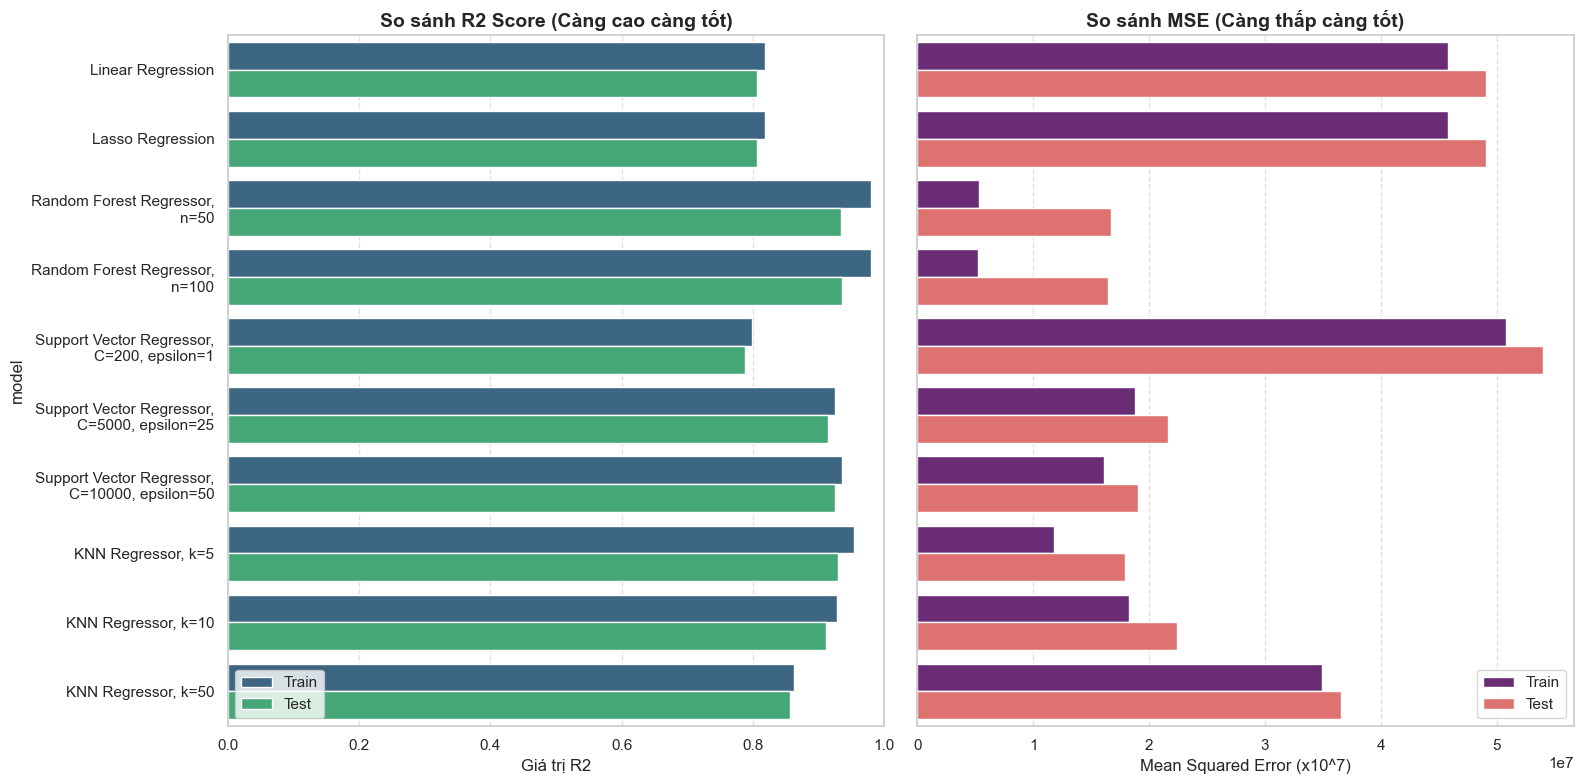

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import textwrap

df_r2 = model_scores.melt(id_vars="model", value_vars=["train_r2", "test_r2"], 
                          var_name="Dataset", value_name="Score")
df_mse = model_scores.melt(id_vars="model", value_vars=["train_mse", "test_mse"], 
                           var_name="Dataset", value_name="Error")

# Đổi tên nhãn cho đẹp (train_r2 -> Train, test_r2 -> Test)
df_r2["Dataset"] = df_r2["Dataset"].replace({"train_r2": "Train", "test_r2": "Test"})
df_mse["Dataset"] = df_mse["Dataset"].replace({"train_mse": "Train", "test_mse": "Test"})

# 3. Vẽ biểu đồ (2 cột cạnh nhau)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# --- Biểu đồ bên trái: R2 Score (Càng cao càng tốt) ---
sns.barplot(ax=axes[0], data=df_r2, x="Score", y="model", hue="Dataset", palette="viridis")
axes[0].set_title("So sánh R2 Score (Càng cao càng tốt)", fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1.0)
axes[0].set_xlabel("Giá trị R2")
axes[0].grid(axis='x', linestyle='--', alpha=0.6)
axes[0].legend(loc='lower left')

# --- Biểu đồ bên phải: MSE (Càng thấp càng tốt) ---
sns.barplot(ax=axes[1], data=df_mse, x="Error", y="model", hue="Dataset", palette="magma")
axes[1].set_title("So sánh MSE (Càng thấp càng tốt)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Mean Squared Error (x10^7)")
axes[1].set_ylabel("") # Ẩn nhãn trục Y bên phải cho đỡ rối
axes[1].grid(axis='x', linestyle='--', alpha=0.6)
axes[1].legend(loc='lower right')

# 4. Xử lý tên Model quá dài (Tự động xuống dòng)
def wrap_labels(ax, width):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        # textwrap.fill giúp ngắt dòng thông minh
        wrapped_text = textwrap.fill(text, width=width)
        labels.append(wrapped_text)
    ax.set_yticklabels(labels)

# Áp dụng ngắt dòng (sau mỗi 25 ký tự)
wrap_labels(axes[0], width=25)

plt.tight_layout()
plt.show()